This notebook fits an Bidirectional Long Term Short Term model for Dection of sarcasm within headlines.

In [1]:
import pandas as pd


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import hstack
from normalizer import Normalizer
import tensorflow as tf
from tensorflow import keras


tf.device = tf.device("gpu")

Load the dataset:

In [2]:
data = pd.read_json("../dataset/Sarcasm_Headlines_Dataset.json", lines = True)

In [3]:
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [5]:
sarcastic_data = data.loc[data["is_sarcastic"]==1]
nonsarcastic_data = data.loc[data["is_sarcastic"]==0][:11724]

data = pd.concat([sarcastic_data, nonsarcastic_data])
data.head(5)

,article_link,headline,is_sarcastic
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
8,https://politics.theonion.com/top-snake-handle...,top snake handler leaves sinking huckabee camp...,1
15,https://entertainment.theonion.com/nuclear-bom...,nuclear bomb detonates during rehearsal for 's...,1
16,https://www.theonion.com/cosby-lawyer-asks-why...,cosby lawyer asks why accusers didn't come for...,1


In [6]:
data = data.sample(frac=1).reset_index(drop=True)

In [7]:
data = data.drop(columns=["article_link"])

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23448 entries, 0 to 23447
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      23448 non-null  object
 1   is_sarcastic  23448 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 366.5+ KB


In [10]:
X = data["headline"]
y = data["is_sarcastic"]

In [11]:
X_matrix = Normalizer().get_embeddings(pd.DataFrame({"text": X}))


[INFO] Trying to create word embeddings for this dataframe using Word2Vec model..
[INFO] Extracting columns containing text from dataframe.
[INFO] Successfully extracted text columns from the dataset.
[INFO] Applying Normalization over text:
[INFO]       - Converting Text into lower case for caseconsistency.
[INFO]       - Extracting only words containing alphabets.
[INFO] Text Normalization is now complete.
[INFO] Attempting further preprocessing using Tokenizer()
[INFO] Fitting a Word2Vec model for this text.
[INFO] Creating an embedding matrix!
[INFO] Word embeddings created! Successfully!


In [12]:
X_train, X_Test, y_train, y_test = train_test_split(X_matrix, y, test_size=0.33, random_state=42)

Let's fit an BiLSTM to this:

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense

# Adjusting for your data shape
input_shape = (100, 100)  # 100 words/tokens each represented by a 100-dimensional vector

model = Sequential([
    Bidirectional(LSTM(64), input_shape=input_shape),  # Adjusted input shape
    Dense(1, activation='sigmoid')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)  # Increased learning rate a bit
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirecti  (None, 128)               84480     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 84609 (330.50 KB)
Trainable params: 84609 (330.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_Test, y_test))


Epoch 1/25
491/491 [==============================] - 17s 31ms/step - loss: 0.6045 - accuracy: 0.6591 - val_loss: 0.6187 - val_accuracy: 0.6406
Epoch 2/25
491/491 [==============================] - 15s 31ms/step - loss: 0.5448 - accuracy: 0.7192 - val_loss: 0.5643 - val_accuracy: 0.6854
Epoch 3/25
491/491 [==============================] - 15s 31ms/step - loss: 0.5290 - accuracy: 0.7341 - val_loss: 0.5130 - val_accuracy: 0.7444
Epoch 4/25
491/491 [==============================] - 15s 31ms/step - loss: 0.5095 - accuracy: 0.7428 - val_loss: 0.5362 - val_accuracy: 0.7273
Epoch 5/25
491/491 [==============================] - 15s 31ms/step - loss: 0.4999 - accuracy: 0.7485 - val_loss: 0.4917 - val_accuracy: 0.7583
Epoch 6/25
491/491 [==============================] - 15s 31ms/step - loss: 0.4957 - accuracy: 0.7523 - val_loss: 0.4780 - val_accuracy: 0.7632
Epoch 7/25
491/491 [==============================] - 15s 31ms/step - loss: 0.4771 - accuracy: 0.7688 - val_loss: 0.4772 - val_accuracy:

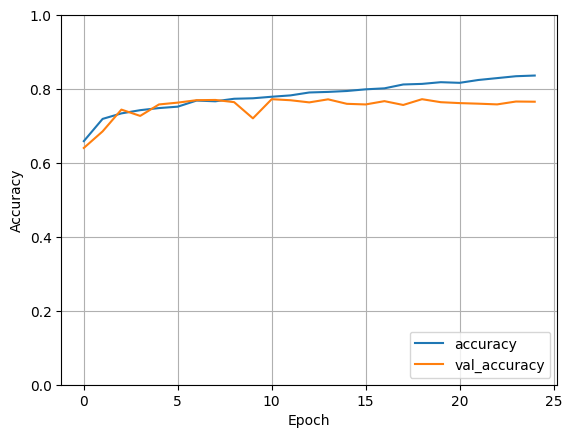

In [30]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid()
plt.show()

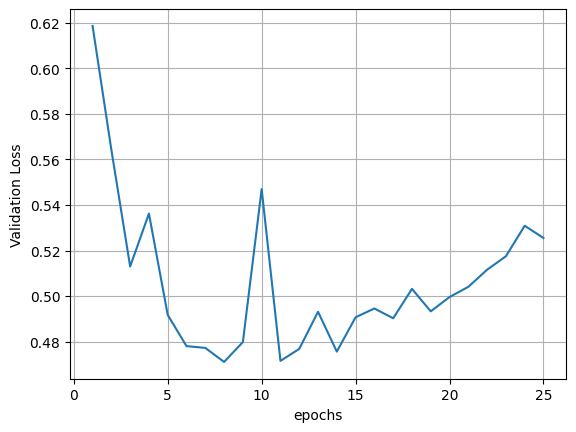

In [32]:
losses = history.history["val_loss"]
plt.plot(range(1,26), losses)
plt.xlabel("epochs")
plt.ylabel("Validation Loss")
plt.grid()
plt.show()

In [34]:
y_pred = model.predict(X_Test)


242/242 [==============================] - 5s 20ms/step


In [35]:
from sklearn.metrics import classification_report
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)


report = classification_report(y_test, y_pred_binary)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.72      0.75      3864
           1       0.74      0.82      0.78      3874

    accuracy                           0.77      7738
   macro avg       0.77      0.77      0.77      7738
weighted avg       0.77      0.77      0.77      7738

